## DUSP1 Confirmation Notebook
The purpose of this notebook is to:
1. Confirm successful segmentation.
2. Confirm successful BigFISH spot and cluster detection.
3. Refine spots and clusters through additional filtering (SNR) for gating and final dataframe preparation (determine if best before or after total concatenation):  
    a. Find SNR threshold.  
    b. Filter `df_spots`.  
    c. (Optional) Check to see if removed spot was in a cluster (very unlikely due to how clusters are defined).  
    d. Create final dataframes (`df_spots`, `df_clusters`, `df_cellspots`, `df_cellprops`).  
    e. Save the dataframes.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns


logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis import AnalysisManager, Analysis, SpotDetection_SNRConfirmation, Spot_Cluster_Analysis_WeightedSNR, GR_Confirmation

c:\Users\formanj\GitHub\AngelFISH


Loads in the data from specified location

In [2]:
loc = None 
log_location = r'\\munsky-nas.engr.colostate.edu\share\Users\Eric\AngelFISH_data'
am = AnalysisManager(location=loc, log_location=log_location, mac=False)

In [3]:
# list all analysis done 
am.list_analysis_names()

Analysis_DUSP1_H_Jan2725_2025-01-27
Analysis_DUSP1_M_Jan2125_2025-01-21
Analysis_DUSP1_D_Jan2125_2025-01-22
Analysis_GR_A_Jan2324_2025-01-24
Analysis_DUSP1_E_Jan2725_2025-01-27
Analysis_demo_2025-01-21
Analysis_demo_2025-01-22
Analysis_ER_Dec0324_DUSP1_2025-01-25
Analysis_DUSP1_L_Jan2725_2025-01-28
Analysis_DUSP1_F_Jan2725_2025-01-27
Analysis_DUSP1_K_Jan2725_2025-01-28
Analysis_DUSP1_G_Jan2725_2025-01-27
Analysis_GR_B_Jan2424_2025-01-25
Analysis_GR_C_Jan2724_2025-01-27
Analysis_DUSP1_I_Jan2725_2025-01-27
Analysis_GR_A_Jan2424_2025-01-24


['Analysis_DUSP1_H_Jan2725_2025-01-27',
 'Analysis_DUSP1_M_Jan2125_2025-01-21',
 'Analysis_DUSP1_D_Jan2125_2025-01-22',
 'Analysis_GR_A_Jan2324_2025-01-24',
 'Analysis_DUSP1_E_Jan2725_2025-01-27',
 'Analysis_demo_2025-01-21',
 'Analysis_demo_2025-01-22',
 'Analysis_ER_Dec0324_DUSP1_2025-01-25',
 'Analysis_DUSP1_L_Jan2725_2025-01-28',
 'Analysis_DUSP1_F_Jan2725_2025-01-27',
 'Analysis_DUSP1_K_Jan2725_2025-01-28',
 'Analysis_DUSP1_G_Jan2725_2025-01-27',
 'Analysis_GR_B_Jan2424_2025-01-25',
 'Analysis_GR_C_Jan2724_2025-01-27',
 'Analysis_DUSP1_I_Jan2725_2025-01-27',
 'Analysis_GR_A_Jan2424_2025-01-24']

In [4]:
# can filter on naDe and dates
am.select_analysis('DUSP1_D_Jan2125')


In [5]:
print(am.analysis_names)
am.location

['Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22', 'Analysis_DUSP1_D_Jan2125_2025-01-22']


['\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220225\\DUSP1_Dex_0min_20220224\\DUSP1_Dex_0min_20220224.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220225\\DUSP1_Dex_10min_20220224\\DUSP1_Dex_10min_20220224.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220305\\DUSP1_Dex_120min_20220224\\DUSP1_Dex_120min_20220224.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220305\\DUSP1_Dex_150min_20220224\\DUSP1_Dex_150min_20220224.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220305\\DUSP1_Dex_180min_20220224\\DUSP1_Dex_180min_20220224.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220225\\DUSP1_Dex_20min_20220224\\DUSP1_Dex_20min_20220224.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220225\\DUSP1_Dex_30min_20220224\\DUSP1_Dex_3

In [6]:
am.list_datasets()

{'bigfish_max_threshold', 'bigfish_median_threshold', 'bigfish_min_threshold', 'spotresults', 'bigfish_90_quartile', 'clusterresults', 'individual_spotdetection_thresholds', 'bigfish_mean_threshold', 'bigfish_std_threshold', 'bigfish_75_quartile', 'position_indexs', 'cellresults', 'cell_properties', 'bigfish_25_quartile'}


Does analysis/confirmation

In [7]:
# select DUSP1 spot detection
# SD = SpotDetection_Confirmation(am)
SD = Spot_Cluster_Analysis_WeightedSNR(am)

In [8]:
# this loads the data into memory 
SD.get_data()

[INFO] Weighted threshold in [2,5): bottom 20% => 2.82
Chose cell_label=1.0 with TS and Spot (FOV=10).


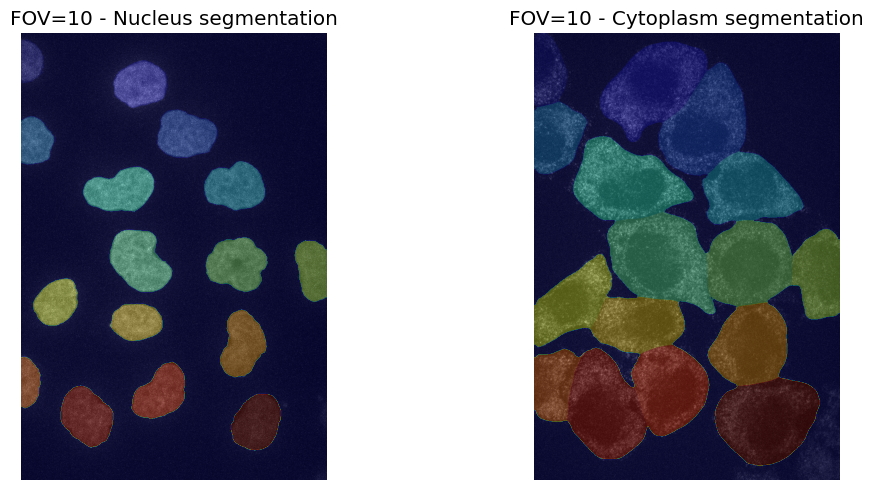

No Foci in this cell


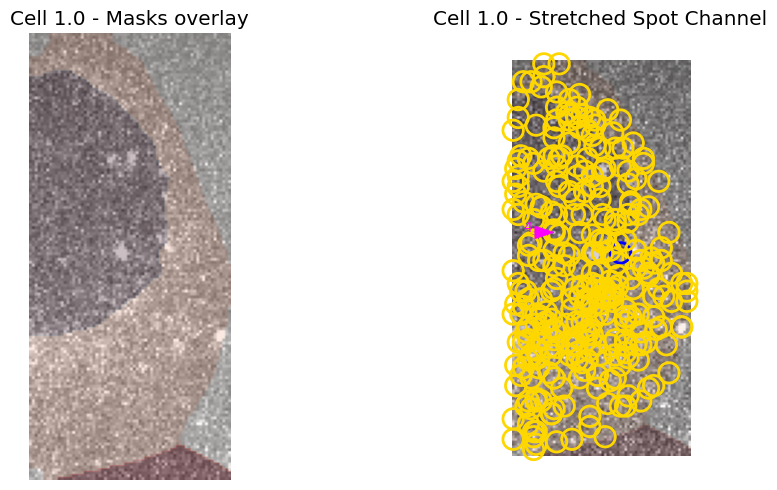

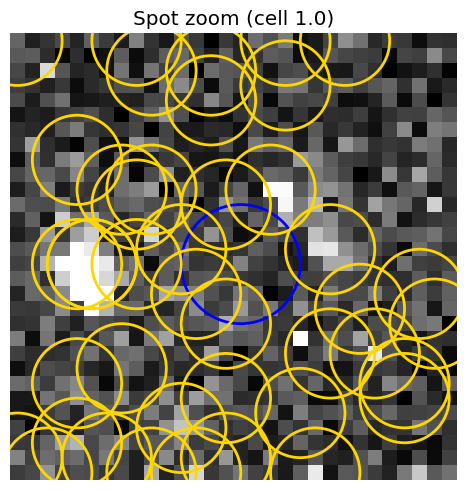

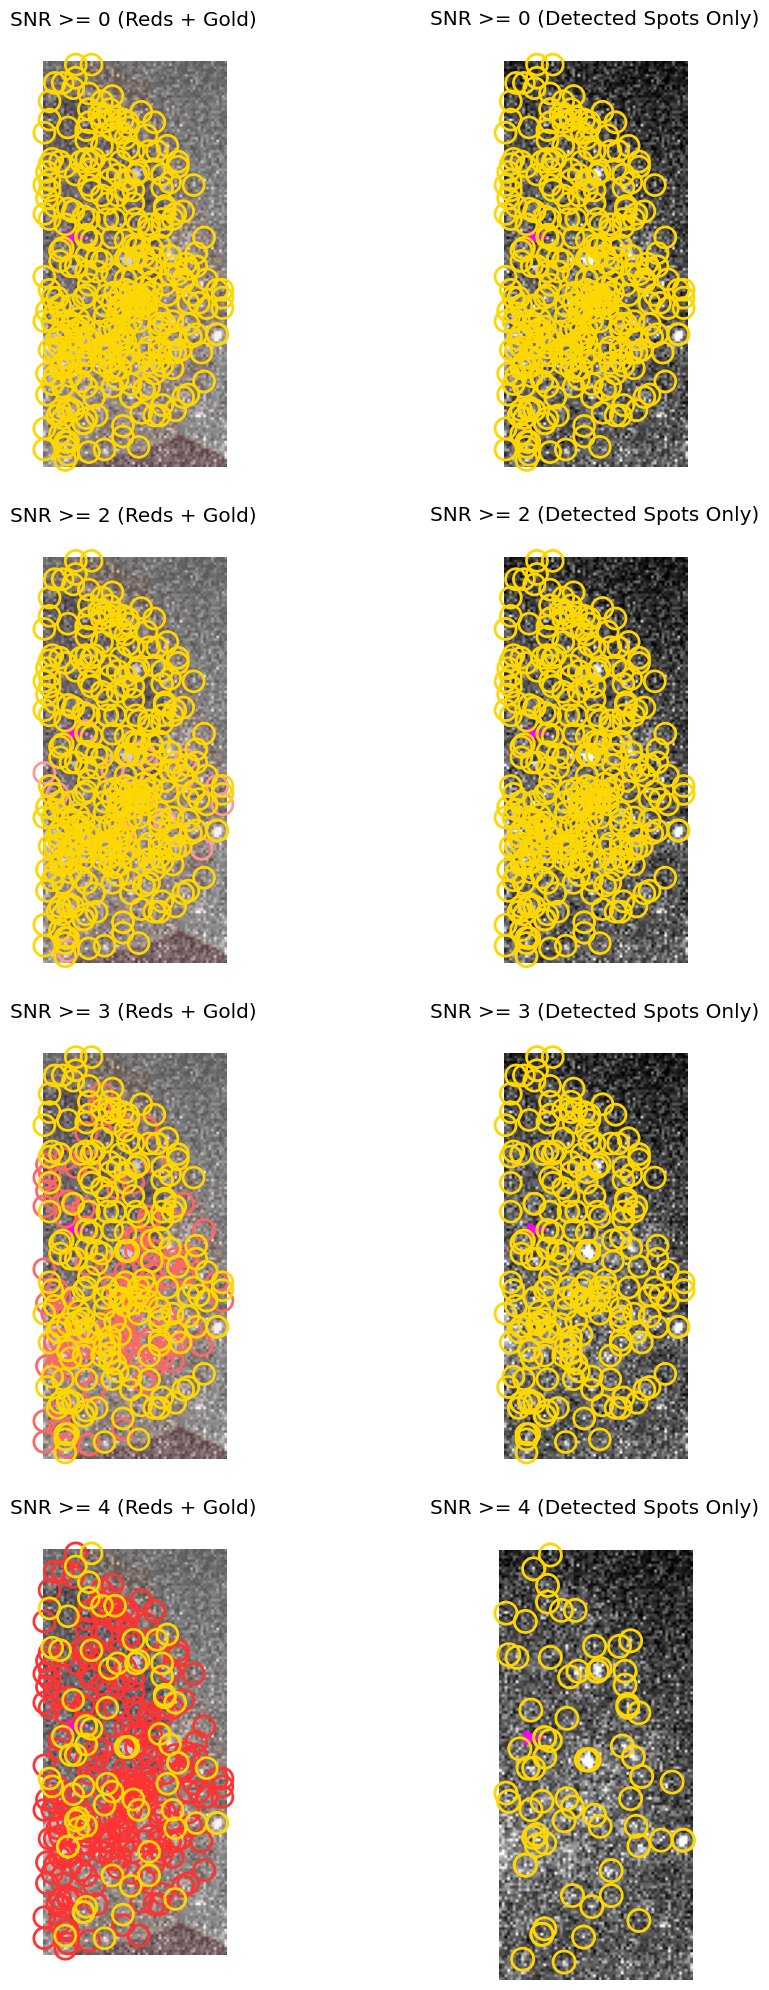

Threshold SNR >= 0: 309 kept / 309 total spots.
Threshold SNR >= 2: 293 kept / 309 total spots.
Threshold SNR >= 3: 200 kept / 309 total spots.
Threshold SNR >= 4: 71 kept / 309 total spots.


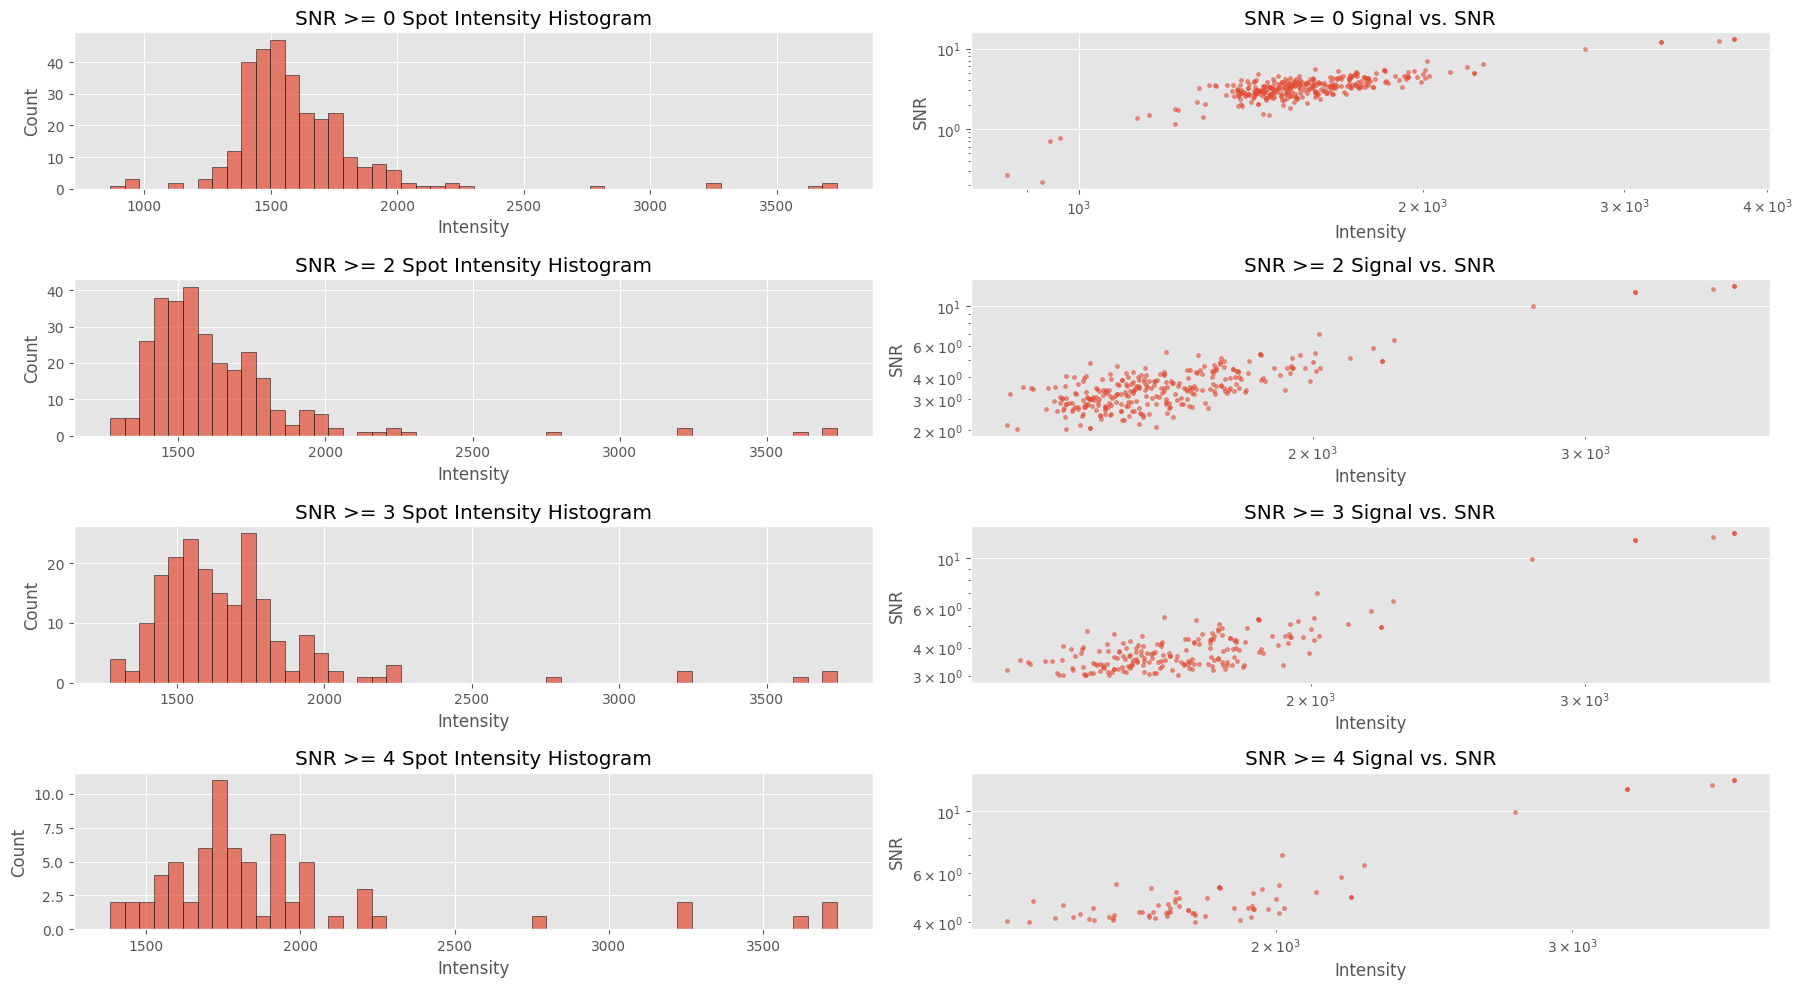

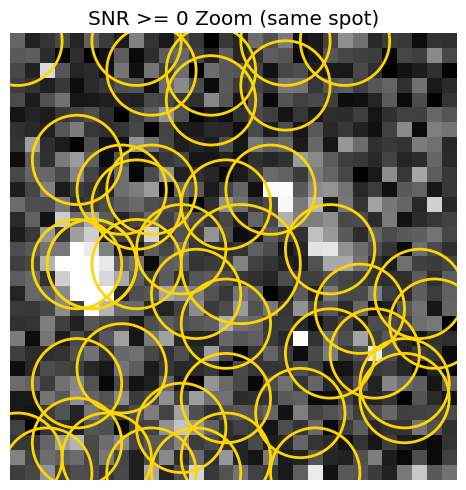

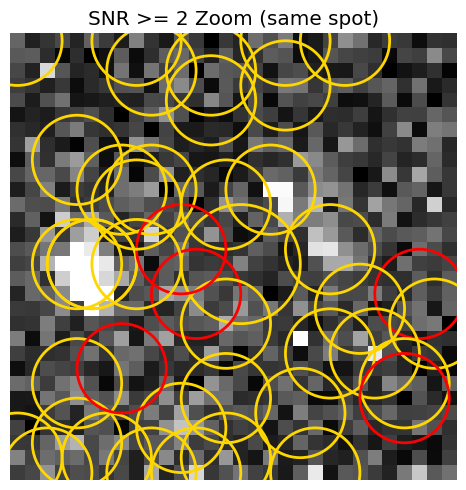

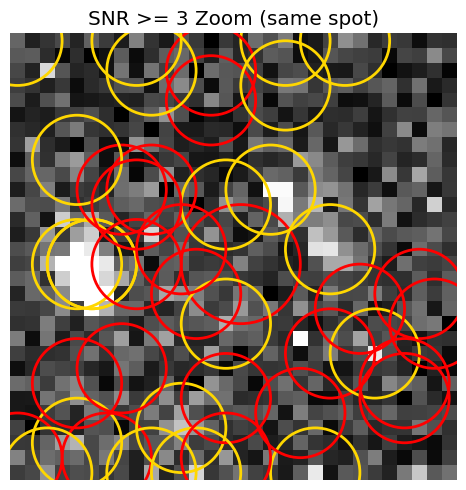

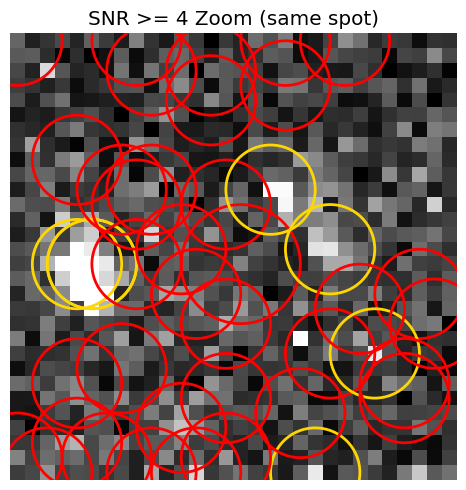

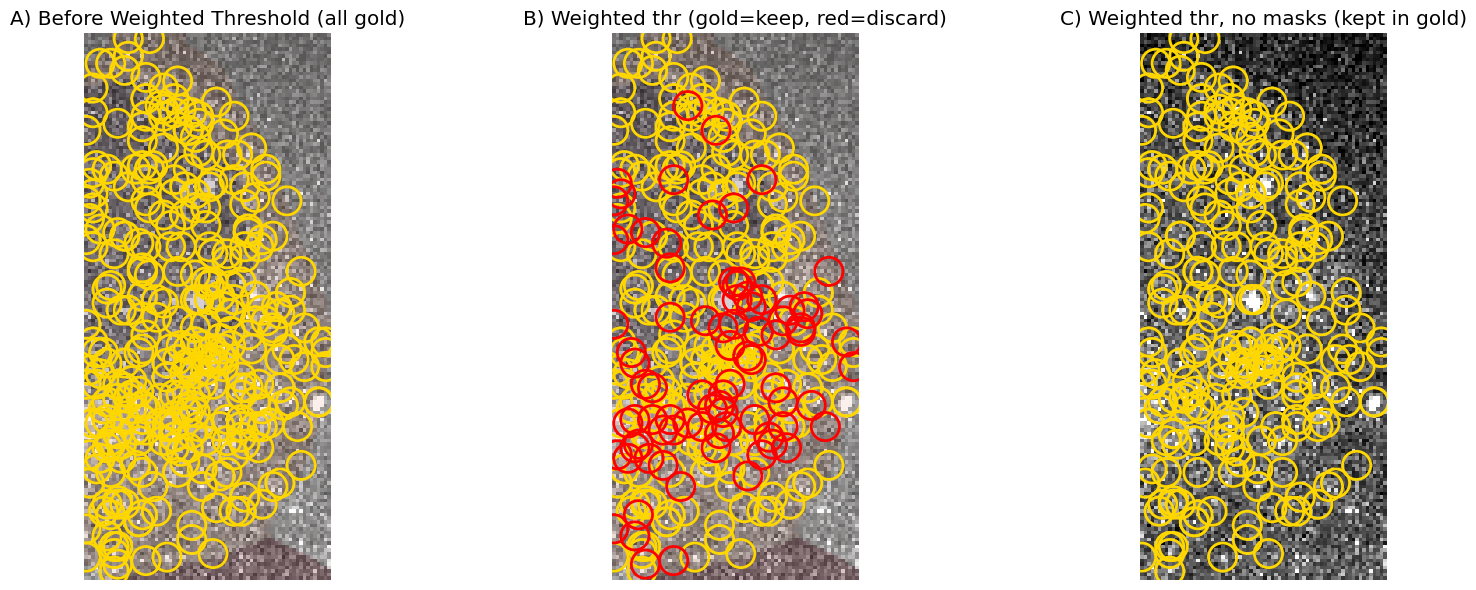

Weighted threshold => kept: 225, discarded: 84


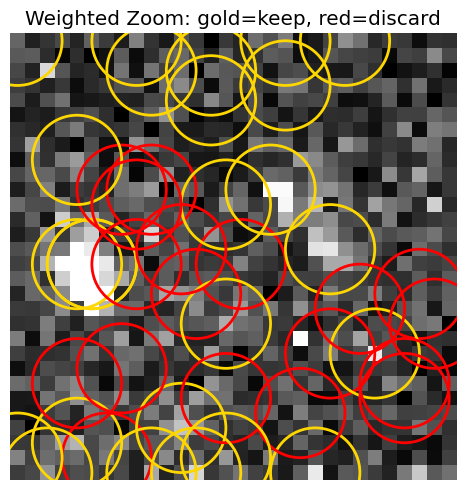

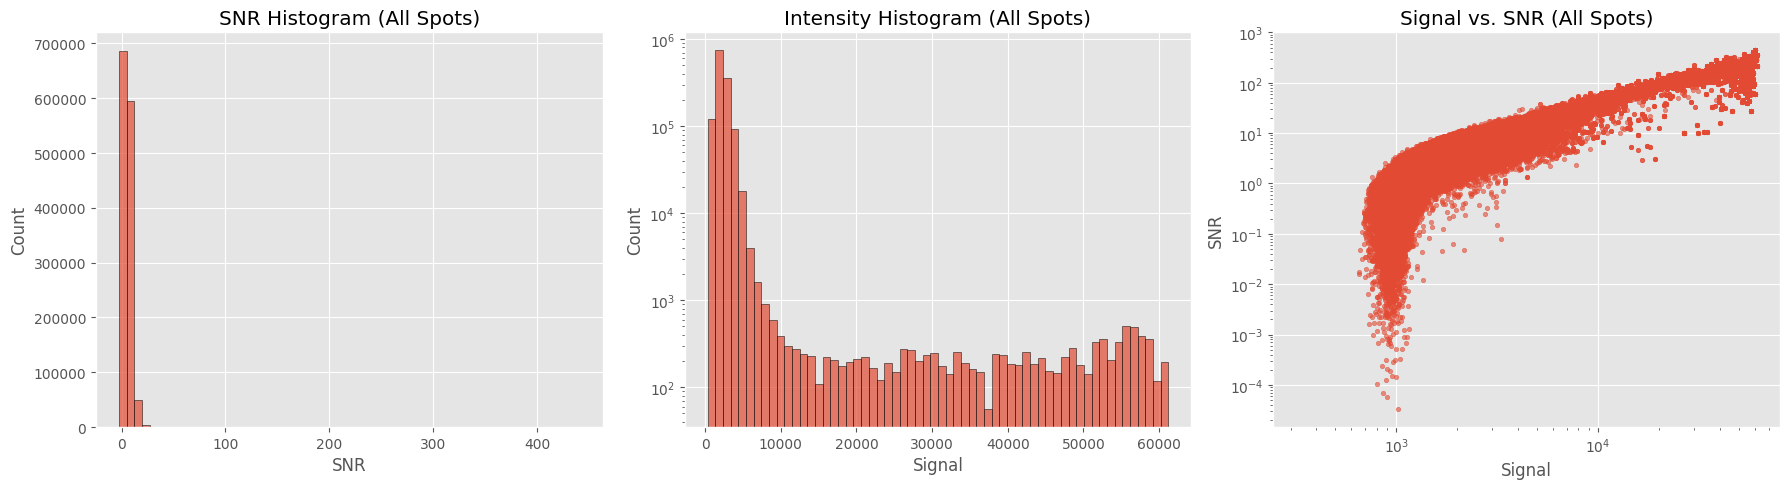

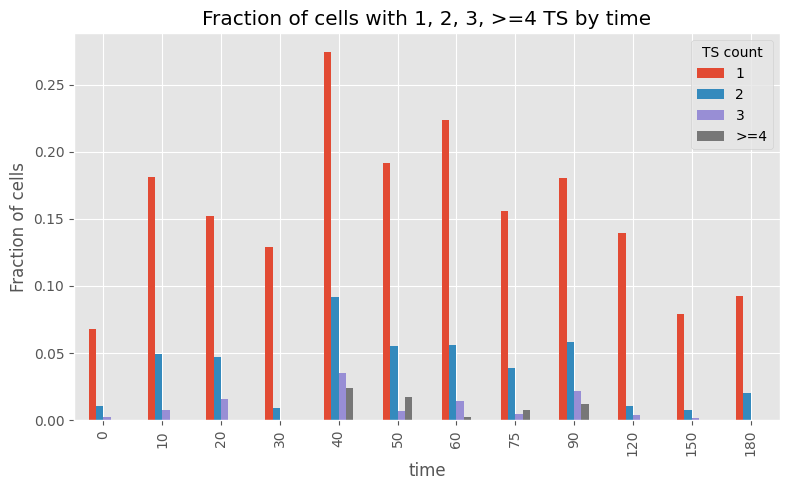

In [9]:
# run this multiple times to see a new randomly selected cell
SD.display(newFOV=True, newCell=True) # num_fovs_to_display=2,num_cells_to_display=2, num_spots_to_display=4

In [10]:
am.close()

In [11]:
# keys
print("Cellprops keys:", SD.cellprops.keys())
print("Cellspots keys:", SD.cellspots.keys())
print("Spots keys:", SD.spots.keys())
print("Clusters keys:", SD.clusters.keys())

Cellprops keys: Index(['nuc_label', 'nuc_bbox-0', 'nuc_bbox-1', 'nuc_bbox-2', 'nuc_bbox-3',
       'nuc_area', 'nuc_centroid-0', 'nuc_centroid-1', 'nuc_intensity_max-0',
       'nuc_intensity_max-1', 'nuc_intensity_max-2', 'nuc_intensity_mean-0',
       'nuc_intensity_mean-1', 'nuc_intensity_mean-2', 'nuc_intensity_min-0',
       'nuc_intensity_min-1', 'nuc_intensity_min-2', 'nuc_intensity_std-0',
       'nuc_intensity_std-1', 'nuc_intensity_std-2', 'cell_label',
       'cell_bbox-0', 'cell_bbox-1', 'cell_bbox-2', 'cell_bbox-3', 'cell_area',
       'cell_centroid-0', 'cell_centroid-1', 'cell_intensity_max-0',
       'cell_intensity_max-1', 'cell_intensity_max-2', 'cell_intensity_mean-0',
       'cell_intensity_mean-1', 'cell_intensity_mean-2',
       'cell_intensity_min-0', 'cell_intensity_min-1', 'cell_intensity_min-2',
       'cell_intensity_std-0', 'cell_intensity_std-1', 'cell_intensity_std-2',
       'touching_border', 'cyto_label', 'cyto_bbox-0', 'cyto_bbox-1',
       'cyto_bbox-

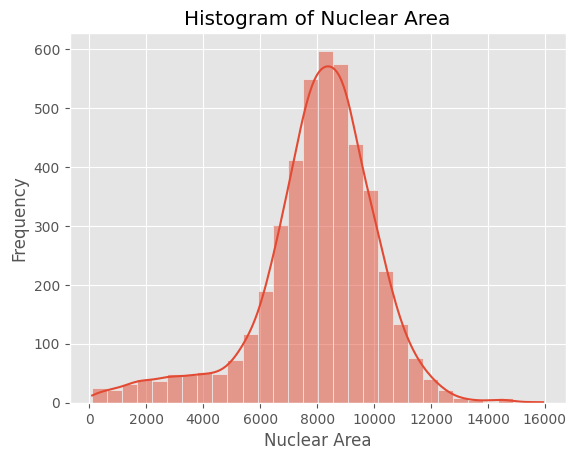

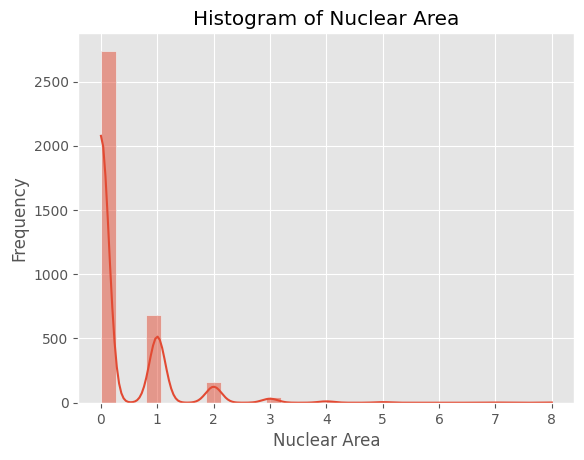

In [12]:
# Filter
# touching border
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]

# by nuc area
sns.histplot(SD.cellprops['nuc_area'], bins=30, kde=True)
plt.xlabel('Nuclear Area')
plt.ylabel('Frequency')
plt.title('Histogram of Nuclear Area')
plt.show()

# Filter cells within 1 standard deviation of the mean nuclear area
mean_nuc_area = SD.cellprops['nuc_area'].mean()
std_nuc_area = SD.cellprops['nuc_area'].std()
SD.cellprops = SD.cellprops[(SD.cellprops['nuc_area'] >= mean_nuc_area - std_nuc_area) & 
                            (SD.cellprops['nuc_area'] <= mean_nuc_area + std_nuc_area)]

# by num ts
sns.histplot(SD.cellspots['nb_transcription_site'], bins=30, kde=True)
plt.xlabel('Nuclear Area')
plt.ylabel('Frequency')
plt.title('Histogram of Nuclear Area')
plt.show()
SD.cellspots = SD.cellspots[SD.cellspots['nb_transcription_site'] == 1] 
SD.clusters = SD.clusters[SD.clusters['is_nuc'] == 1]

# snr
SD.spots = SD.spots[SD.spots['keep_wsnr']]


In [17]:
# add unique cell id to all dataframes
if not 'unique_cell_id' in SD.cellprops.keys():
    SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
    SD.cellspots = SD.cellspots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                                        left_on=['NAS_location', 'cell_id', 'fov'], 
                                        right_on=['NAS_location', 'cell_label', 'fov'], 
                                        how='left')
    SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                                on=['NAS_location', 'cell_label', 'fov'], 
                                how='left')
    SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                                on=['NAS_location', 'cell_label', 'fov'], 
                                how='left')

In [18]:
# apply filters to all dataframes on uci
common_uci = set(SD.cellprops['unique_cell_id']).intersection(SD.cellspots['unique_cell_id'], 
                                                              SD.spots['unique_cell_id'], 
                                                              SD.clusters['unique_cell_id'])

SD.cellprops = SD.cellprops[SD.cellprops['unique_cell_id'].isin(common_uci)]
SD.cellspots = SD.cellspots[SD.cellspots['unique_cell_id'].isin(common_uci)]
SD.spots = SD.spots[SD.spots['unique_cell_id'].isin(common_uci)]
SD.clusters = SD.clusters[SD.clusters['unique_cell_id'].isin(common_uci)]


In [19]:
# reindex based on unqiue cell id 
SD.cellprops.set_index('unique_cell_id', inplace=True)
SD.cellspots.set_index('unique_cell_id', inplace=True)
SD.clusters.set_index('unique_cell_id', inplace=True)


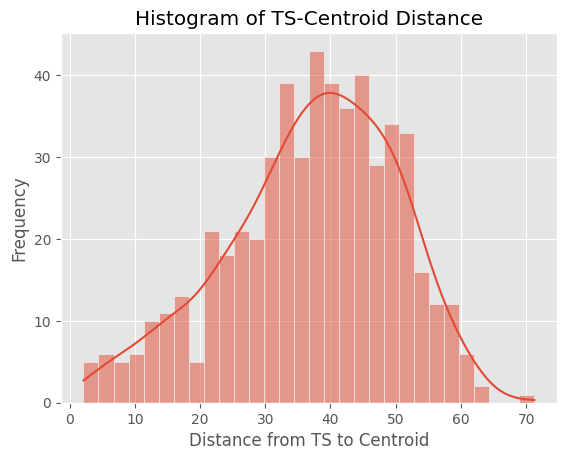

In [ ]:
# bin by ts-centriod distance
SD.cellprops['ts-cent_dist-0'] = SD.cellprops['nuc_centroid-0'] - SD.clusters['y_px']
SD.cellprops['ts-cent_dist-1'] = SD.cellprops['nuc_centroid-1'] - SD.clusters['x_px']
SD.cellprops['ts-cent_dist'] = np.sqrt(SD.cellprops['ts-cent_dist-0']**2 + SD.cellprops['ts-cent_dist-1']**2)

sns.histplot(SD.cellprops['ts-cent_dist'], bins=30, kde=True)
plt.xlabel('Distance from TS to Centroid')
plt.ylabel('Frequency')
plt.title('Histogram of TS-Centroid Distance')
plt.show()

# confirmation 
# the mean distance is roughly 40 pixels, which is 5200 nm assuming 130 nm per pixel
# this is 5.2 um which is roughly the radius of a hela cell nucleus
# most transcription occurs on the perifery of the nucleus

In [40]:
# bin cells based on ts to centroid distances 
# Define bins for 'close', 'medium', and 'far' based on ts-centroid distance
bins = [0, 20, 40, np.inf]
labels = ['close', 'medium', 'far']

# Bin the cells based on ts-centroid distance
SD.cellprops['ts_centroid_bin'] = pd.cut(SD.cellprops['ts-cent_dist'], bins=bins, labels=labels)

# Display the distribution of cells in each bin
print(SD.cellprops['ts_centroid_bin'].value_counts())

ts_centroid_bin
far       243
medium    240
close      60
Name: count, dtype: int64


In [42]:
# filter dfs so that only far ts cells are considered
SD.cellprops = SD.cellprops[SD.cellprops['ts_centroid_bin'] == 'far']
# apply filters to all dataframes on uci
common_uci = set(SD.cellprops.index).intersection(SD.cellspots.index, 
                                                              SD.spots['unique_cell_id'], 
                                                              SD.clusters.index)

SD.cellprops = SD.cellprops[SD.cellprops.index.isin(common_uci)]
SD.cellspots = SD.cellspots[SD.cellspots.index.isin(common_uci)]
SD.spots = SD.spots[SD.spots['unique_cell_id'].isin(common_uci)]
SD.clusters = SD.clusters[SD.clusters.index.isin(common_uci)]

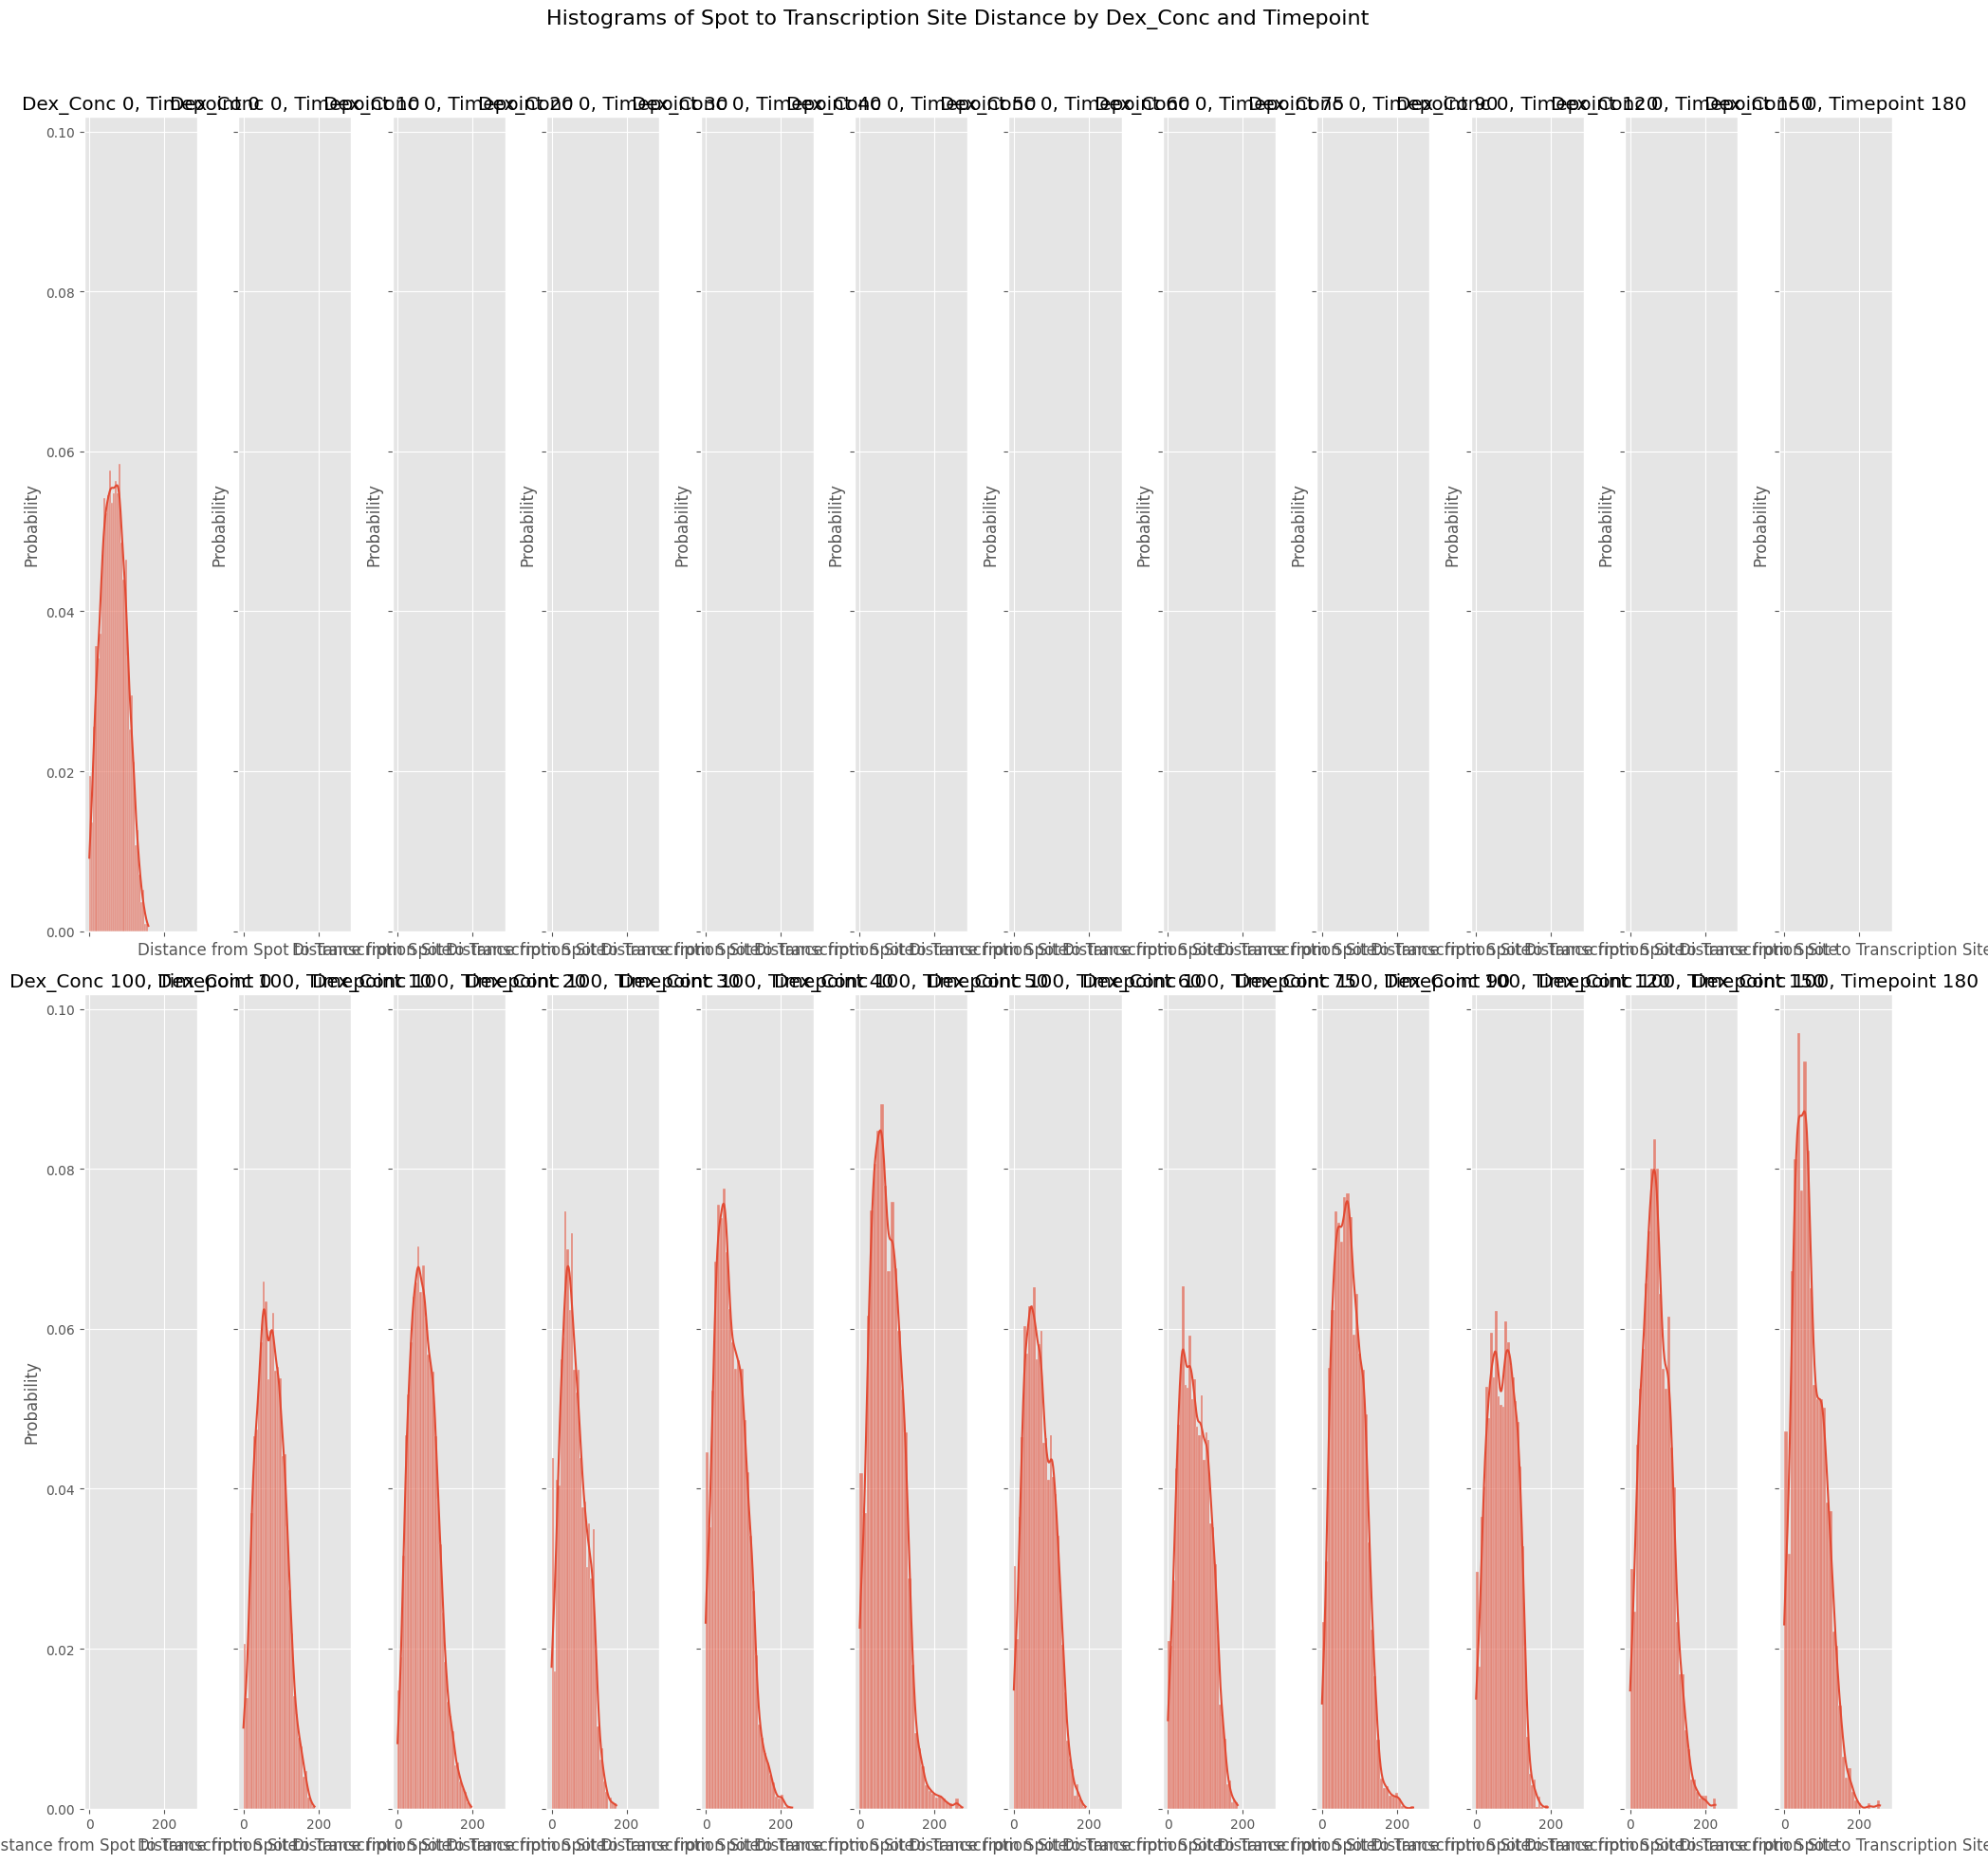

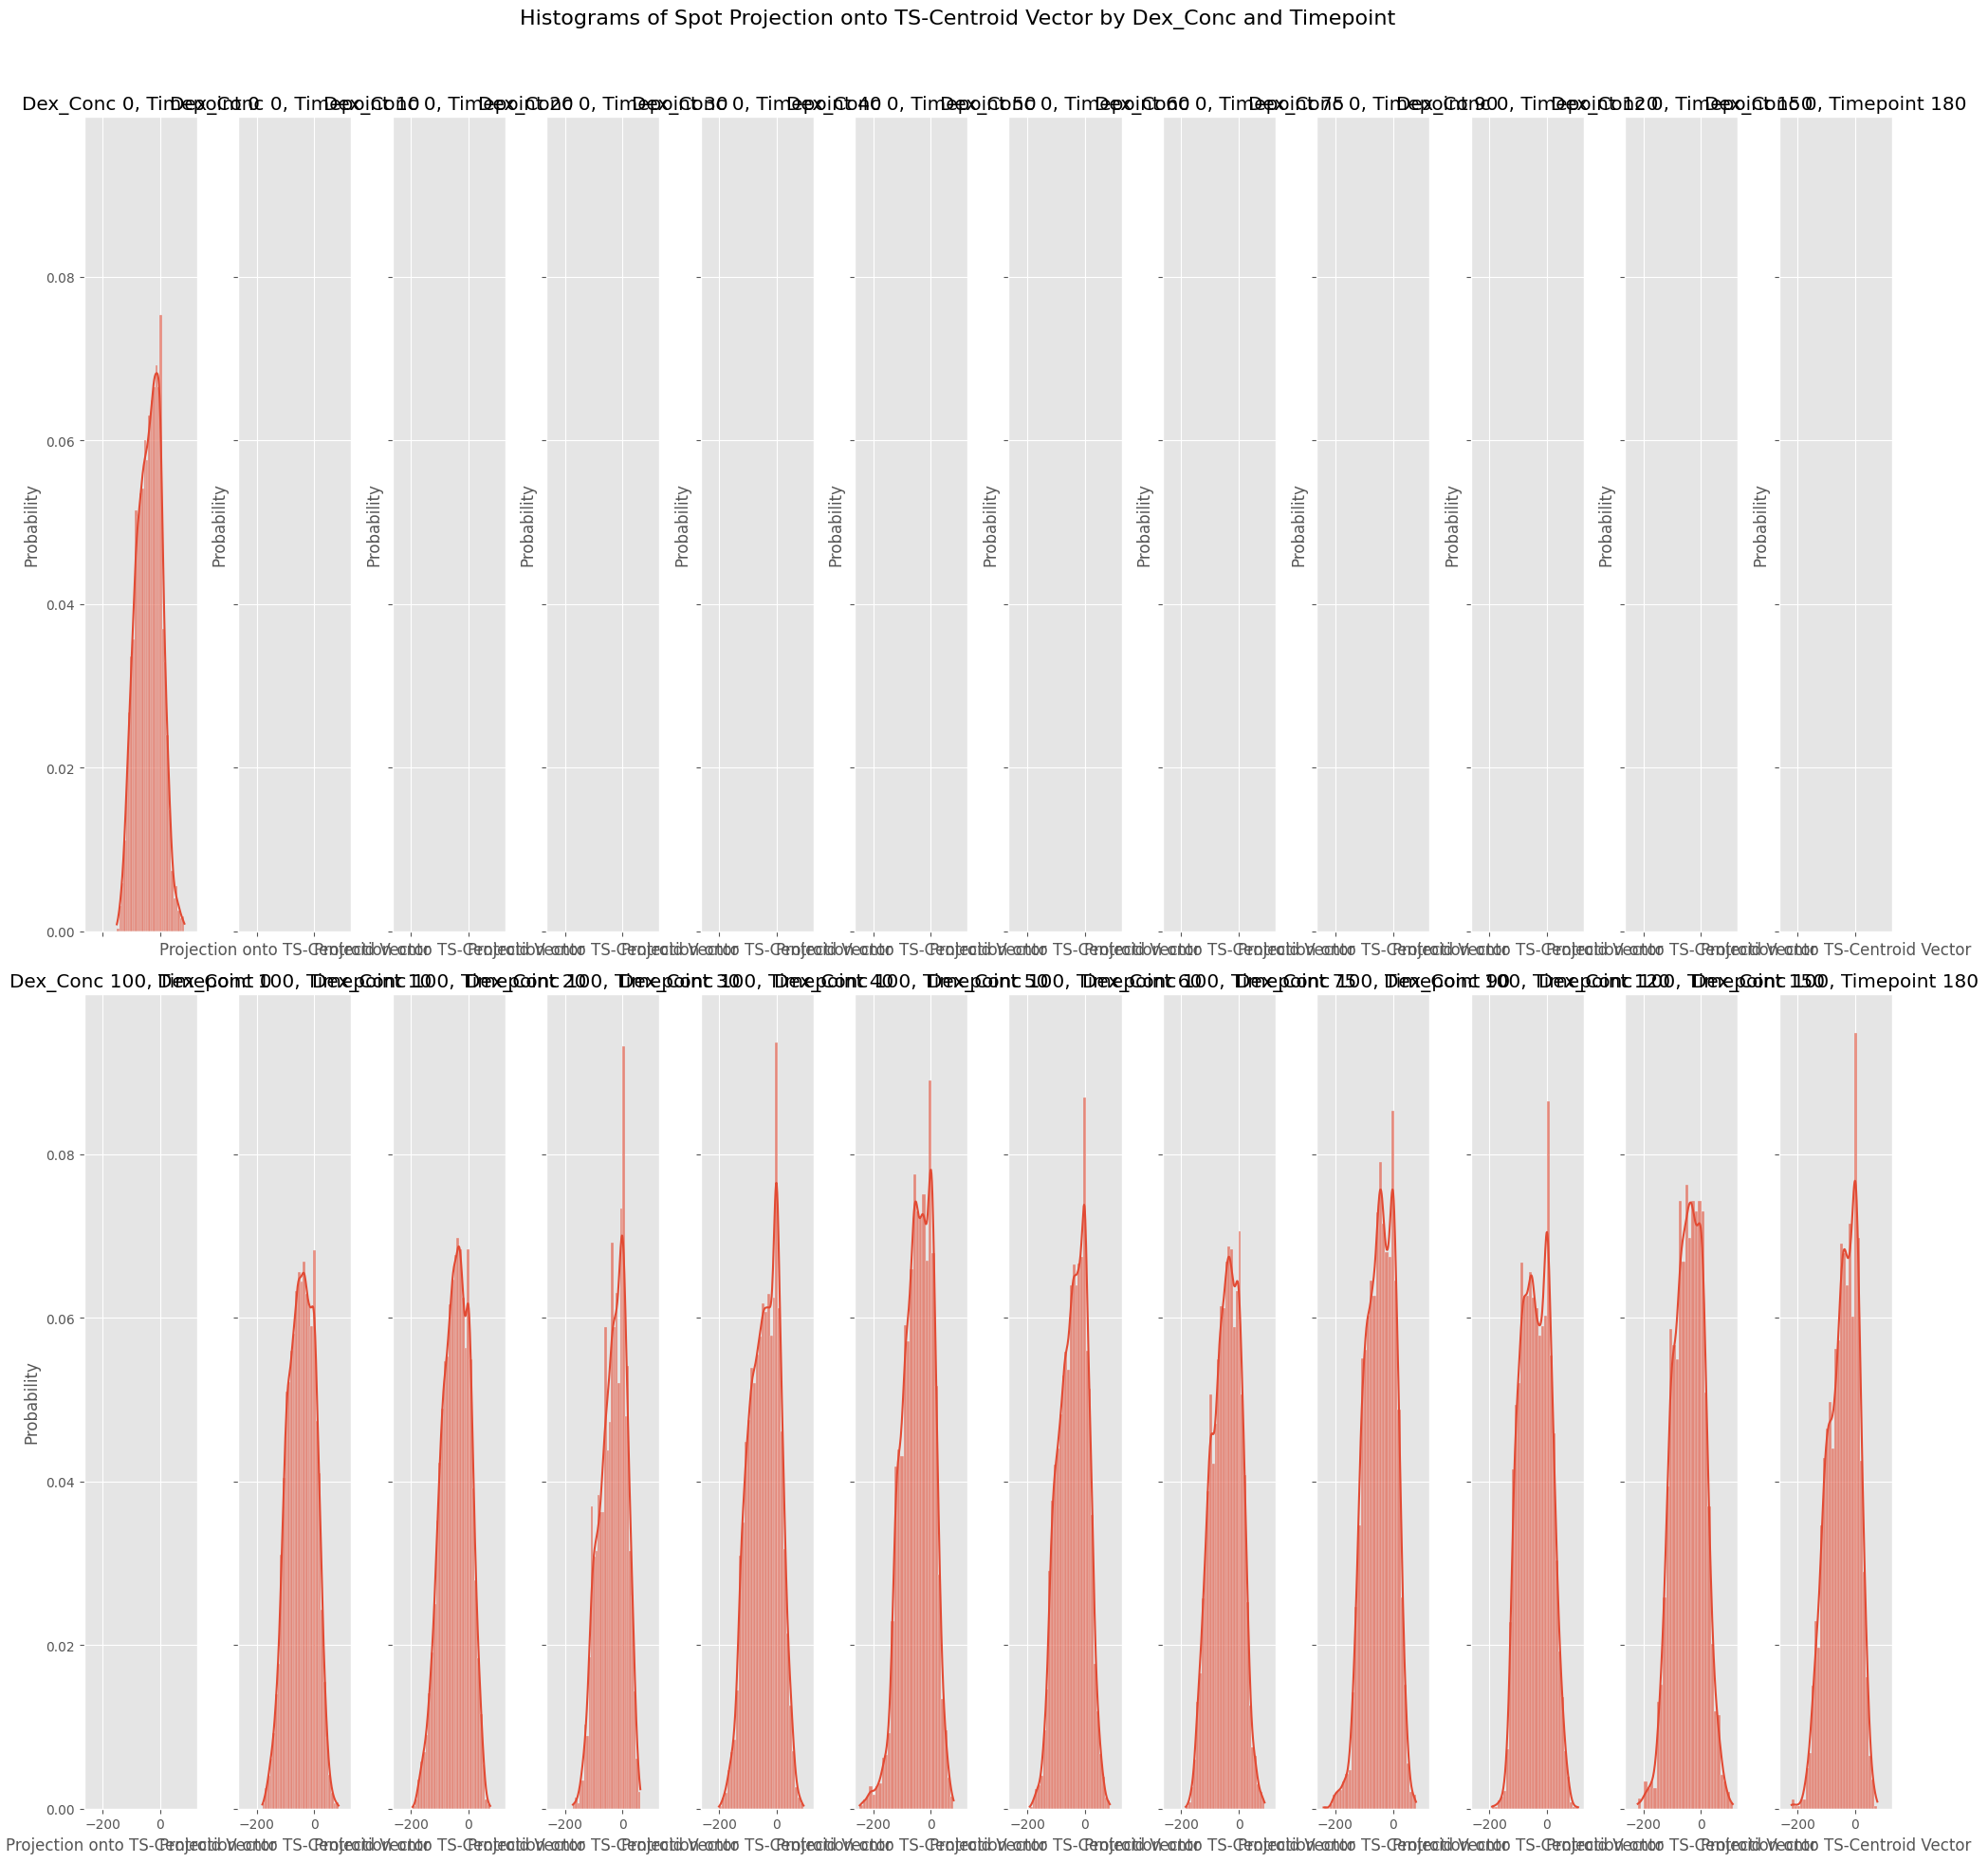

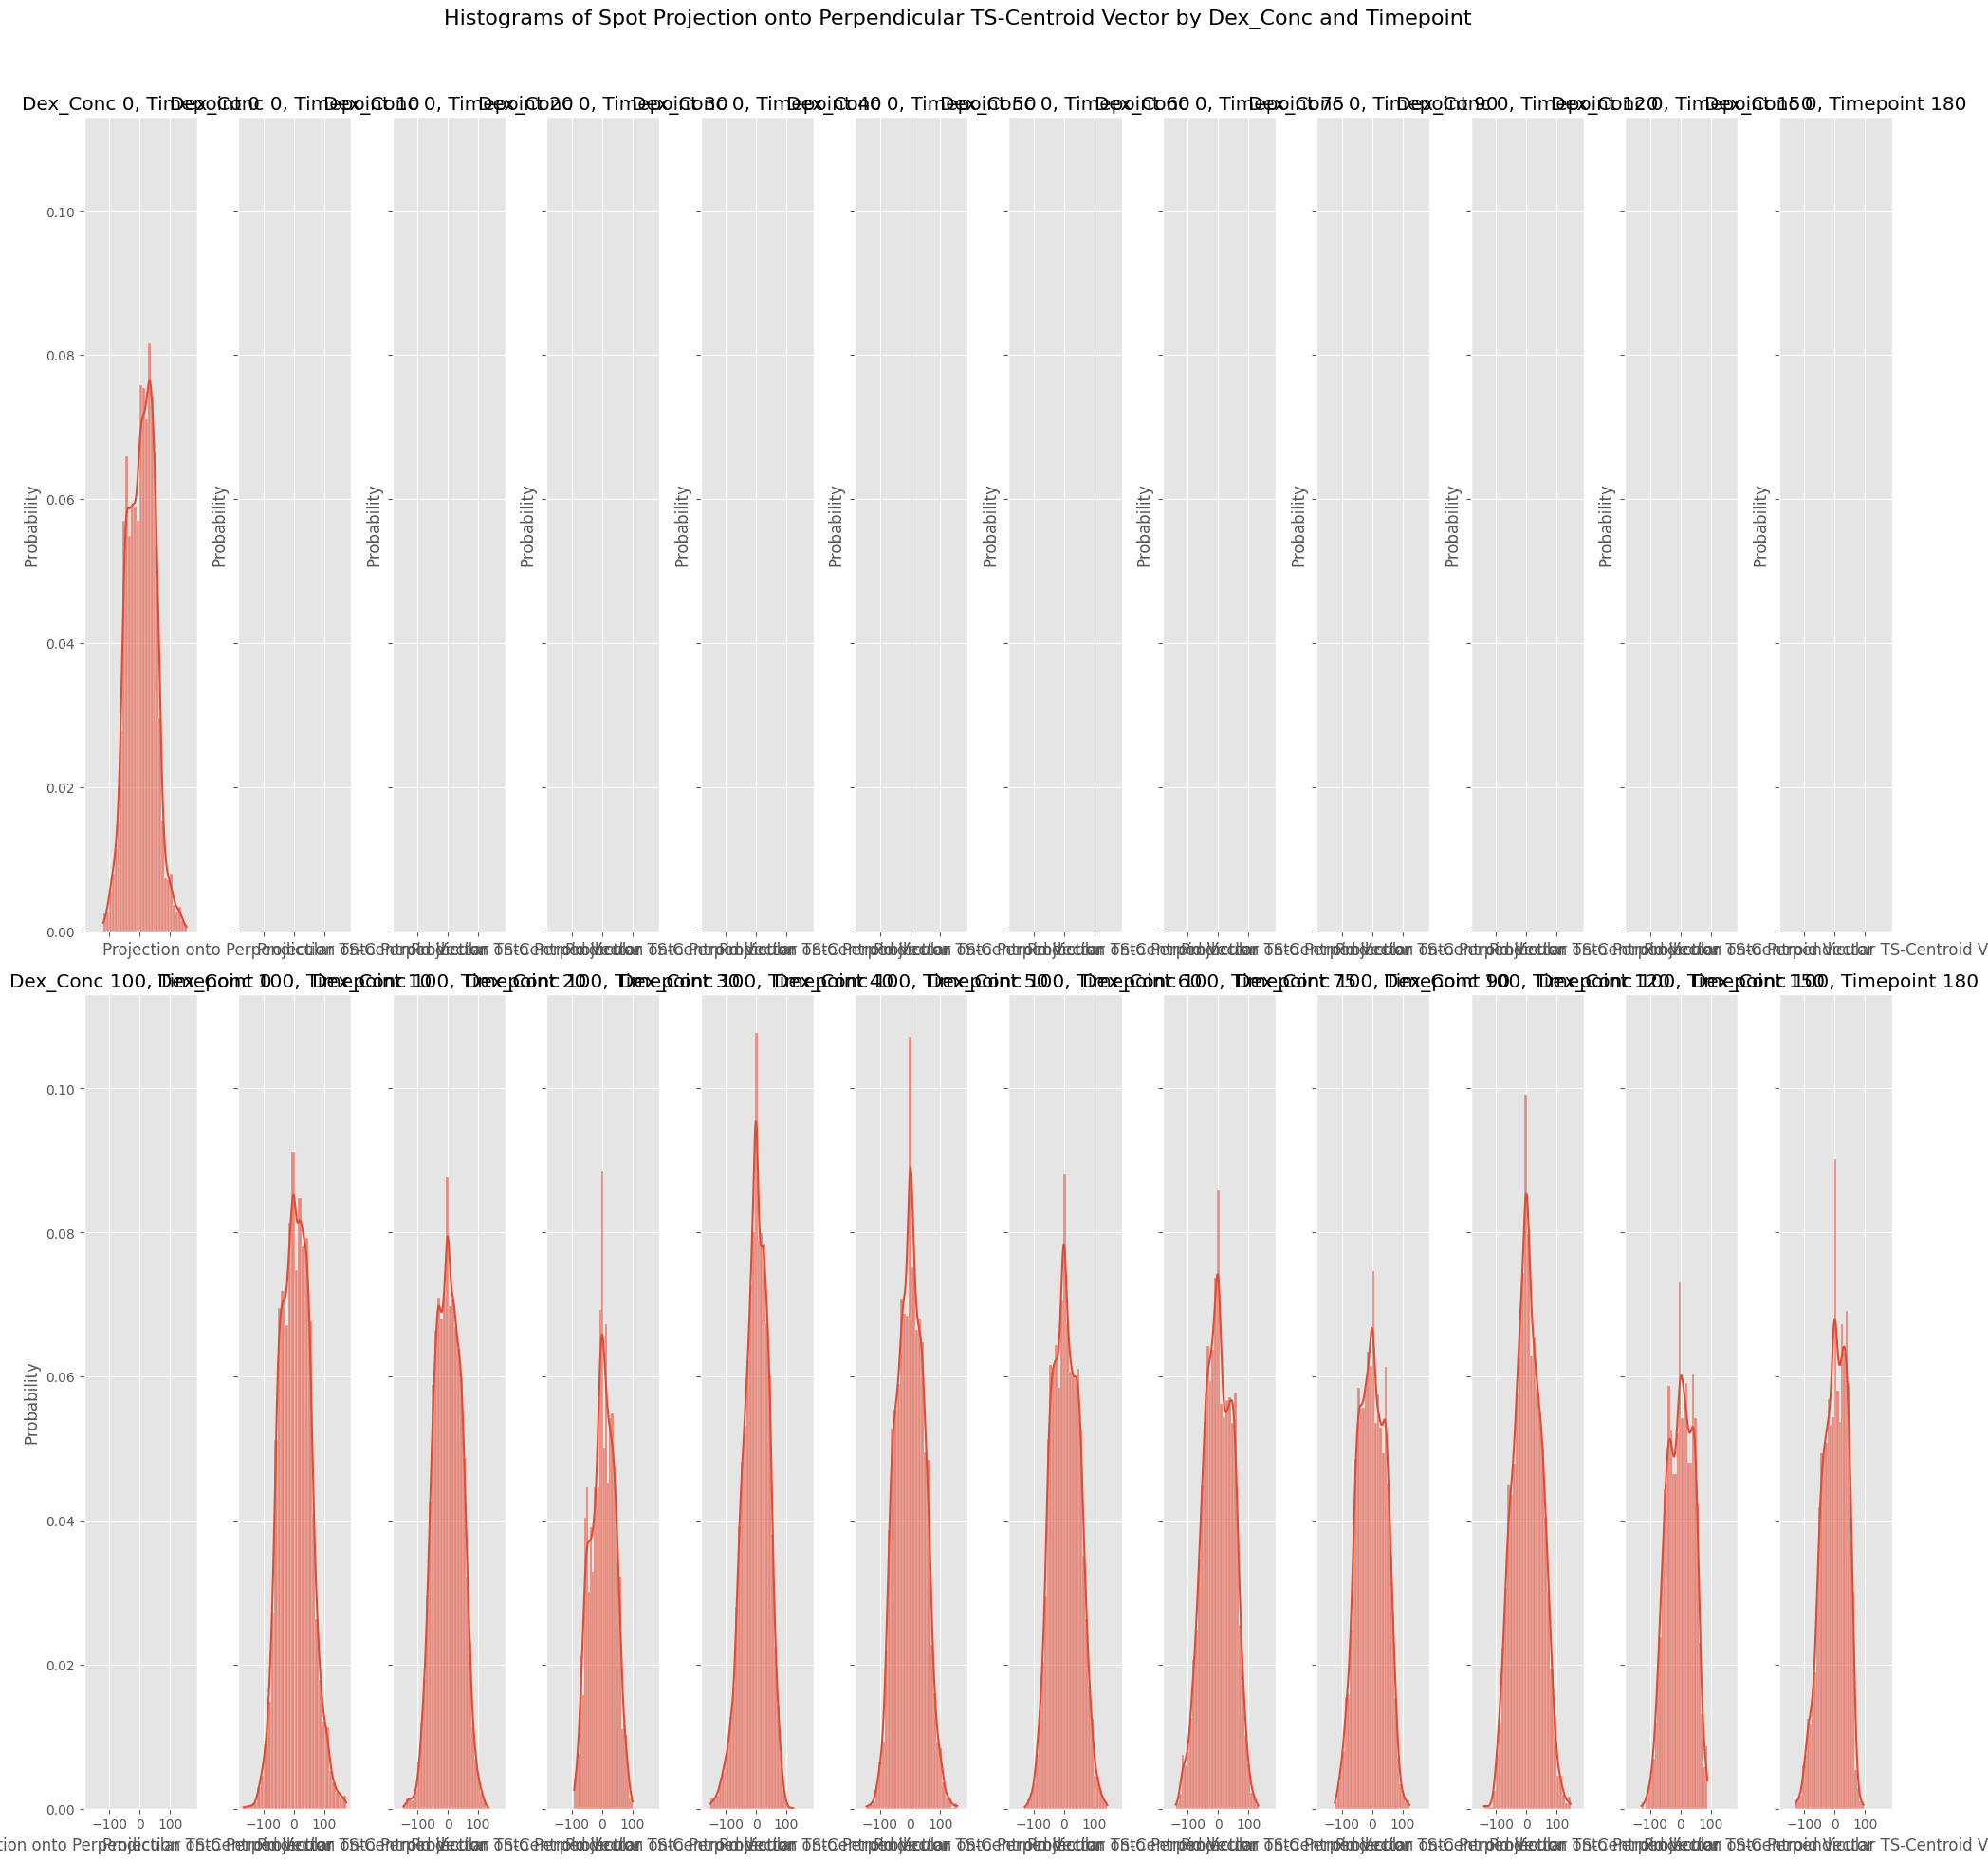

In [43]:
# measure histograms
# distance from ts-spot
# Merge spots DataFrame with clusters DataFrame on unique_cell_id
merged_df = SD.spots.merge(SD.clusters[['y_px', 'x_px']], left_on='unique_cell_id', right_index=True, suffixes=('_spot', '_ts'))

# Calculate the distance for each spot to the corresponding transcription site
merged_df['ts_dist-0'] = merged_df['y_px_spot'] - merged_df['y_px_ts']
merged_df['ts_dist-1'] = merged_df['x_px_spot'] - merged_df['x_px_ts']
merged_df['ts_dist'] = np.sqrt(merged_df['ts_dist-0']**2 + merged_df['ts_dist-1']**2)

# Create a histogram for each Dex_Conc and timepoint
timepoints = np.sort(np.unique(merged_df['time']))
dex_concs = np.sort(np.unique(merged_df['Dex_Conc']))

fig, axes = plt.subplots(len(dex_concs), len(timepoints), figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle('Histograms of Spot to Transcription Site Distance by Dex_Conc and Timepoint', fontsize=16)

for i, dex_conc in enumerate(dex_concs):
    for j, timepoint in enumerate(timepoints):
        subset_df = merged_df[(merged_df['Dex_Conc'] == dex_conc) & (merged_df['time'] == timepoint)]
        ax = axes[i, j]
        sns.histplot(subset_df['ts_dist'], bins=30, kde=True, stat="probability", alpha=0.6, ax=ax)
        ax.set_title(f'Timepoint {timepoint}')
        ax.set_xlabel('Distance from Spot to Transcription Site')
        ax.set_ylabel('Probability')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# project spot onto ts-centroid vector
merged_df['centroid_ts_vector-0'] = merged_df['y_px_ts'] - SD.cellprops.loc[merged_df['unique_cell_id'], 'nuc_centroid-0'].values
merged_df['centroid_ts_vector-1'] = merged_df['x_px_ts'] - SD.cellprops.loc[merged_df['unique_cell_id'], 'nuc_centroid-1'].values

# Normalize the centroid_ts_vector
norm = np.sqrt(merged_df['centroid_ts_vector-0']**2 + merged_df['centroid_ts_vector-1']**2)
merged_df['centroid_ts_vector-0'] /= norm
merged_df['centroid_ts_vector-1'] /= norm

# Project spot onto the normalized centroid_ts_vector
merged_df['projection'] = (merged_df['ts_dist-0'] * merged_df['centroid_ts_vector-0'] + 
                           merged_df['ts_dist-1'] * merged_df['centroid_ts_vector-1'])

# Create a histogram for each Dex_Conc and timepoint
fig, axes = plt.subplots(len(dex_concs), len(timepoints), figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle('Histograms of Spot Projection onto TS-Centroid Vector by Dex_Conc and Timepoint', fontsize=16)

for i, dex_conc in enumerate(dex_concs):
    for j, timepoint in enumerate(timepoints):
        subset_df = merged_df[(merged_df['Dex_Conc'] == dex_conc) & (merged_df['time'] == timepoint)]
        ax = axes[i, j]
        sns.histplot(subset_df['projection'], bins=30, kde=True, stat="probability", alpha=0.6, ax=ax)
        ax.set_title(f'Timepoint {timepoint}')
        ax.set_xlabel('Projection onto TS-Centroid Vector')
        ax.set_ylabel('Probability')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# project spot onto perpendicular ts-centroid vector
# Calculate the perpendicular vector to centroid_ts_vector
merged_df['perp_centroid_ts_vector-0'] = -merged_df['centroid_ts_vector-1']
merged_df['perp_centroid_ts_vector-1'] = merged_df['centroid_ts_vector-0']

# Project spot onto the perpendicular centroid_ts_vector
merged_df['perp_projection'] = (merged_df['ts_dist-0'] * merged_df['perp_centroid_ts_vector-0'] + 
                                merged_df['ts_dist-1'] * merged_df['perp_centroid_ts_vector-1'])

# Create a histogram for each Dex_Conc and timepoint
fig, axes = plt.subplots(len(dex_concs), len(timepoints), figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle('Histograms of Spot Projection onto Perpendicular TS-Centroid Vector by Dex_Conc and Timepoint', fontsize=16)

for i, dex_conc in enumerate(dex_concs):
    for j, timepoint in enumerate(timepoints):
        subset_df = merged_df[(merged_df['Dex_Conc'] == dex_conc) & (merged_df['time'] == timepoint)]
        ax = axes[i, j]
        sns.histplot(subset_df['perp_projection'], bins=30, kde=True, stat="probability", alpha=0.6, ax=ax)
        ax.set_title(f'Timepoint {timepoint}')
        ax.set_xlabel('Projection onto Perpendicular TS-Centroid Vector')
        ax.set_ylabel('Probability')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



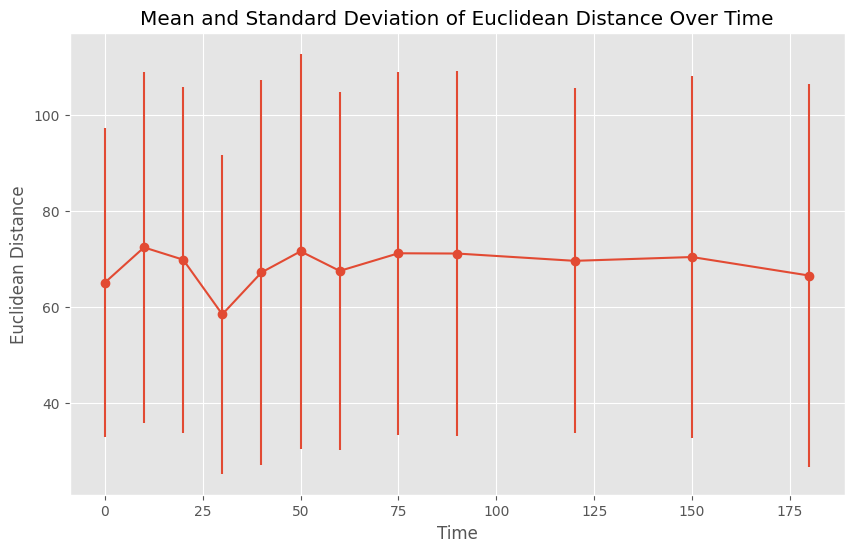

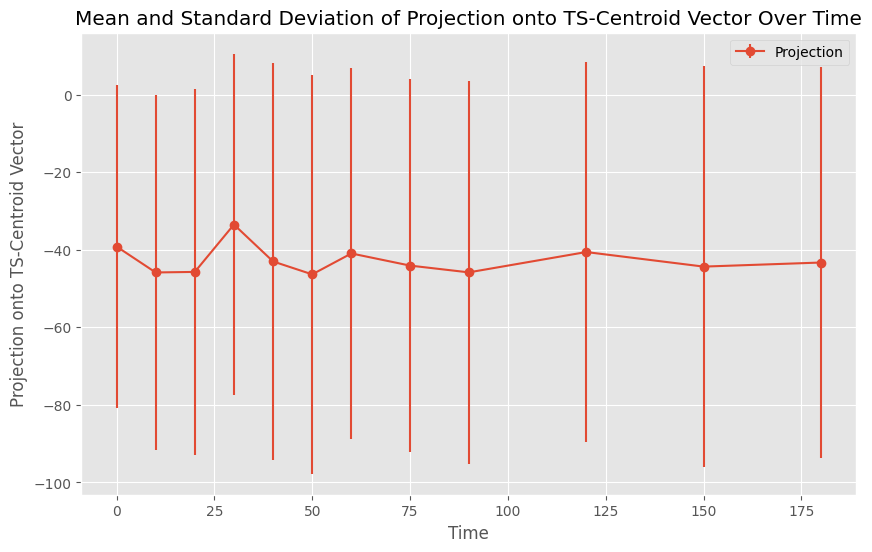

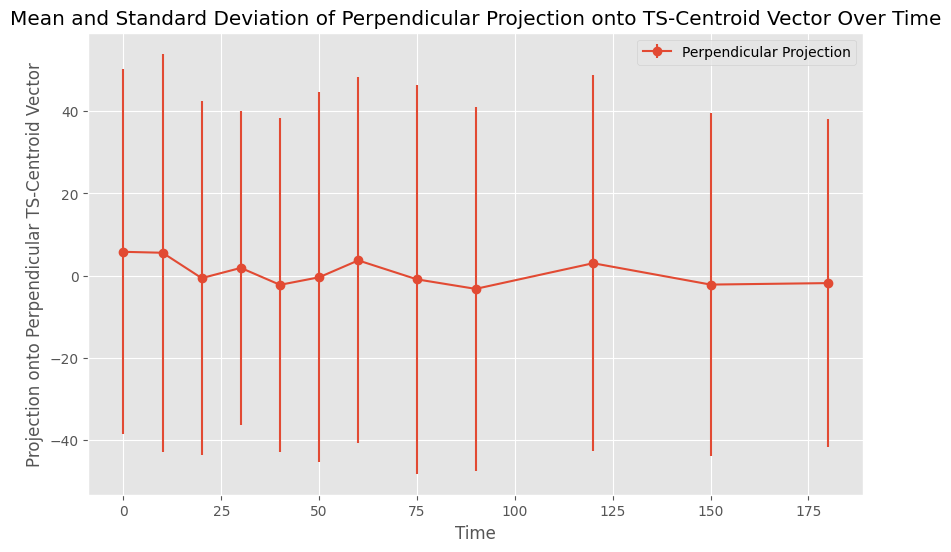

In [44]:
# plot the mean and standard deviation of the previous plot over time
# Calculate mean and standard deviation of the Euclidean distance over time
mean_ts_dist = merged_df.groupby('time')['ts_dist'].mean()
std_ts_dist = merged_df.groupby('time')['ts_dist'].std()

# Plot mean and standard deviation of the Euclidean distance over time
plt.figure(figsize=(10, 6))
plt.errorbar(mean_ts_dist.index, mean_ts_dist, yerr=std_ts_dist, fmt='-o', label='Euclidean Distance')
plt.xlabel('Time')
plt.ylabel('Euclidean Distance')
plt.title('Mean and Standard Deviation of Euclidean Distance Over Time')


# Calculate mean and standard deviation of the projection and perpendicular projection over time
mean_projection = merged_df.groupby('time')['projection'].mean()
std_projection = merged_df.groupby('time')['projection'].std()
mean_perp_projection = merged_df.groupby('time')['perp_projection'].mean()
std_perp_projection = merged_df.groupby('time')['perp_projection'].std()

# Plot mean and standard deviation of the projection over time
plt.figure(figsize=(10, 6))
plt.errorbar(mean_projection.index, mean_projection, yerr=std_projection, fmt='-o', label='Projection')
plt.xlabel('Time')
plt.ylabel('Projection onto TS-Centroid Vector')
plt.title('Mean and Standard Deviation of Projection onto TS-Centroid Vector Over Time')
plt.legend()
plt.show()

# Plot mean and standard deviation of the perpendicular projection over time
plt.figure(figsize=(10, 6))
plt.errorbar(mean_perp_projection.index, mean_perp_projection, yerr=std_perp_projection, fmt='-o', label='Perpendicular Projection')
plt.xlabel('Time')
plt.ylabel('Projection onto Perpendicular TS-Centroid Vector')
plt.title('Mean and Standard Deviation of Perpendicular Projection onto TS-Centroid Vector Over Time')
plt.legend()
plt.show()